# Train a model with negative log-likelihood instead

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import gaussian_kde

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EmbeddingGenerator(nn.Module):
    def __init__(self, input_dim=1, n_layers=4, hidden_dim=50, embedding_dim=100, device='cuda'):
        super(EmbeddingGenerator, self).__init__()

        self.device = device

        layers = []
        for i in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(hidden_dim, embedding_dim))

        self.model = nn.Sequential(*layers)
        self.model.to(self.device)

        # Freeze weights
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.model(x.to(self.device))
        return x

emb_model = EmbeddingGenerator(input_dim=1)
emb_model

EmbeddingGenerator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=50, out_features=100, bias=True)
  )
)

In [ ]:
torch.manual_seed(0)

n = 100000
t = torch.bernoulli(torch.ones(n) * 0.2)
y = torch.normal(t - 0.5, torch.ones(n)).unsqueeze(1)
x = emb_model(y)

# Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, _, t_test = train_test_split(x, y, t, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [4]:
class GaussianRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.mu_head = nn.Linear(64, 1)
        self.log_sigma2_head = nn.Linear(64, 1)  # outputs log(σ²) to ensure positivity

    def forward(self, x):
        features = self.net(x)
        mu = self.mu_head(features)
        log_sigma2 = self.log_sigma2_head(features)
        return mu, log_sigma2


In [5]:
def gaussian_nll(y_true, mu, log_sigma2):
    # log_sigma2 = log(σ²)
    return 0.5 * torch.mean(
        log_sigma2 + ((y_true - mu) ** 2) / torch.exp(log_sigma2)
    )


In [6]:
model = GaussianRegressor().cuda()
x_train = x_train.cuda()
y_train = y_train.cuda()
x_val = x_val.cuda()
y_val = y_val.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 2000

min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    mu, log_sigma2 = model(x_train)
    loss = gaussian_nll(y_train, mu, log_sigma2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Validation
    with torch.no_grad():
        model.eval()
        mu_val, log_sigma2_val = model(x_val)
        val_loss = gaussian_nll(y_val, mu_val, log_sigma2_val)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

GaussianRegressor(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
  )
  (mu_head): Linear(in_features=64, out_features=1, bias=True)
  (log_sigma2_head): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
# Get predictions
model.eval()
with torch.no_grad():
    mu, log_sigma2 = model(x_test.unsqueeze(1))
    sigma = torch.exp(log_sigma2 / 2)

mu = mu.squeeze().cpu().numpy()
sigma = sigma.squeeze().cpu().numpy()
y_test = y_test.squeeze().cpu().numpy()
t_test = t_test.squeeze().cpu().numpy()

## Model evaluation

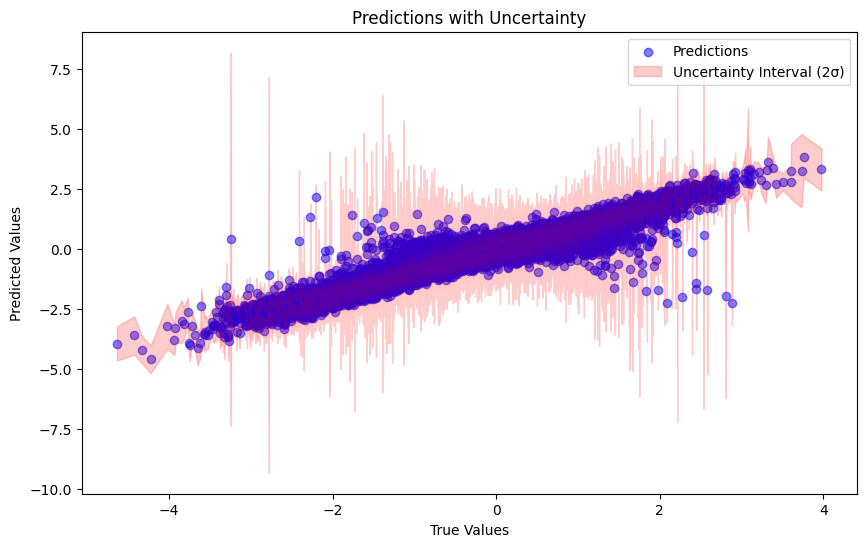

In [25]:
# Convert to numpy and sort for plotting
indices = np.argsort(y_test)
y_sorted = y_test[indices]
mu_sorted = mu[indices]
sigma_sorted = sigma[indices]

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_sorted, mu_sorted, alpha=0.5, label='Predictions', color='blue')
plt.fill_between(
    y_sorted,
    (mu_sorted - 2 * sigma_sorted),
    (mu_sorted + 2 * sigma_sorted),
    alpha=0.2,
    color='red',
    label='Uncertainty Interval (2σ)',
)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions with Uncertainty')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, mu)
r2 = r2_score(y_test, mu)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.1287335604429245
R² Score: 0.8875027080380682


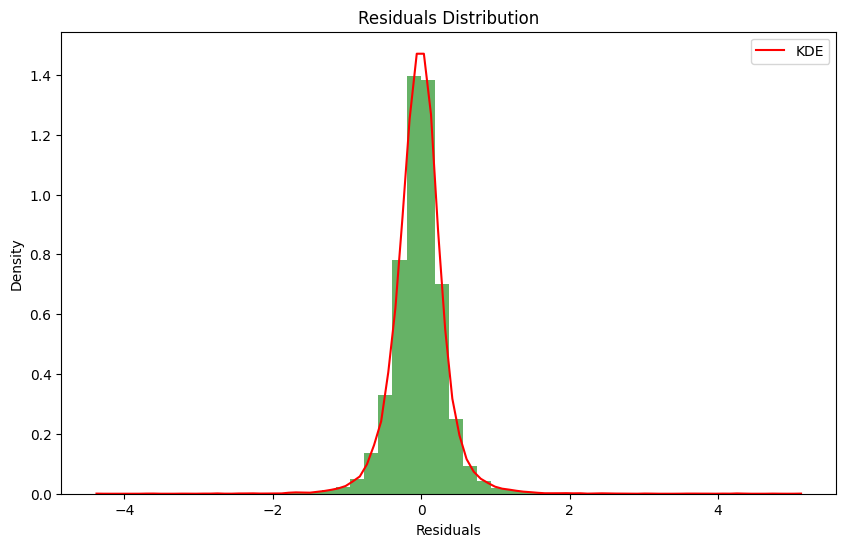

In [27]:
# Plot residuals histogram
plt.figure(figsize=(10, 6))
residuals = (y_test - mu)
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='g')
kde = gaussian_kde(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, kde(x), color='red', label='KDE')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals Distribution')
plt.legend()
plt.show()

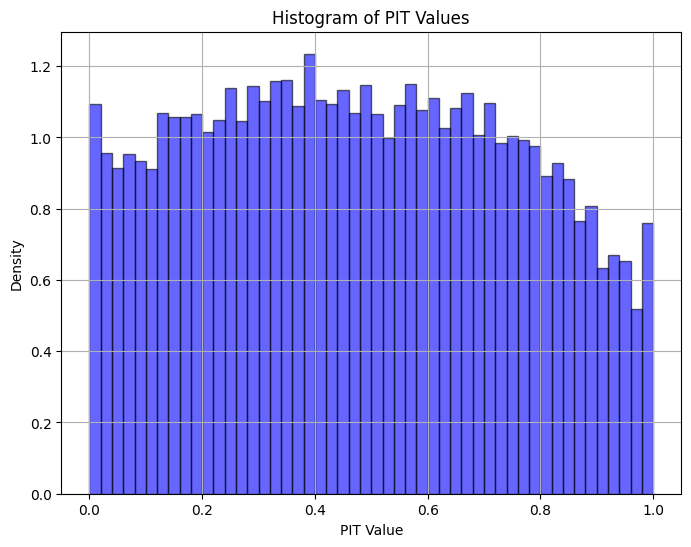

KS Statistic: 0.04800000000000004, p-value: 1.8408530224221873e-20


In [31]:
from scipy.stats import norm

pit_values = norm.cdf((y_test - mu) / sigma)

# Plot the histogram of PIT values to check if they are uniformly distributed
plt.figure(figsize=(8, 6))
plt.hist(pit_values, bins=50, range=(0, 1), density=True, alpha=0.6, color='b', edgecolor='black')
plt.title("Histogram of PIT Values")
plt.xlabel("PIT Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Optionally, perform a uniformity test (e.g., KS test)
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(pit_values, np.random.uniform(0, 1, size=len(pit_values)))

print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

## Estimate treatment effects

In [9]:
treated_mean = y_test[t_test == 1].mean()
control_mean = y_test[t_test == 0].mean()

predicted_treated_mean = mu[t_test == 1].mean()
predicted_control_mean = mu[t_test == 0].mean()
print(f"True Treated Mean: {treated_mean.item():.4f}, Predicted Treated Mean: {predicted_treated_mean:.4f}")
print(f"True Control Mean: {control_mean.item():.4f}, Predicted Control Mean: {predicted_control_mean:.4f}")

True Treated Mean: 0.4938, Predicted Treated Mean: 0.4196
True Control Mean: -0.5203, Predicted Control Mean: -0.4707


In [10]:
z = (mu.squeeze() / sigma.squeeze()).cpu().numpy()
z_kde = gaussian_kde(z)

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

scores = np.asarray([score_function(z_i, z_kde) for z_i in z])
adj_scores = scores * sigma.squeeze().cpu().numpy()

In [11]:
treated_mean = y_test[t_test == 1].mean()
control_mean = y_test[t_test == 0].mean()

predicted_treated_mean = mu[t_test == 1].mean()
predicted_control_mean = mu[t_test == 0].mean()

adjusted_treated_mean = mu[t_test == 1].mean() - adj_scores[t_test == 1].mean()
adjusted_control_mean = mu[t_test == 0].mean() - adj_scores[t_test == 0].mean()

print(f"True Treated Mean: {treated_mean.item():.4f}, Predicted Treated Mean: {predicted_treated_mean:.4f}, Adjusted Treated Mean: {adjusted_treated_mean:.4f}")
print(f"True Control Mean: {control_mean.item():.4f}, Predicted Control Mean: {predicted_control_mean:.4f}, Adjusted Control Mean: {adjusted_control_mean:.4f}")

True Treated Mean: 0.4938, Predicted Treated Mean: 0.4196, Adjusted Treated Mean: 0.4709
True Control Mean: -0.5203, Predicted Control Mean: -0.4707, Adjusted Control Mean: -0.4862


In [12]:
ate = treated_mean - control_mean
predicted_ate = predicted_treated_mean - predicted_control_mean
adjusted_ate = adjusted_treated_mean - adjusted_control_mean
print(f"True ATE: {ate.item():.4f}, Predicted ATE: {predicted_ate:.4f}, Adjusted ATE: {adjusted_ate:.4f}")

True ATE: 1.0141, Predicted ATE: 0.8903, Adjusted ATE: 0.9571
